## **Routing with Research (tools)**

In [14]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.tools import WikipediaQueryRun
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from langchain.tools import tool

## **TOOLS**


In [15]:
# web search tool
@tool
def search_duckduckgo(query: str) -> str:
    """This tool searches the latest news on DuckDuckGo for the given query and returns the results."""
    duck_search = DuckDuckGoSearchRun()
    return duck_search.invoke(query)


# Wikipedia Search Tool
@tool
def wiki_tool(query: str):
    """This tool allows you to search Wikipedia for information on a given topic."""
    wiki_query = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    return wiki_query.invoke(query)


tool_kit = [search_duckduckgo, wiki_tool]

In [16]:
# llm schema
class llm_schema(BaseModel):
    topic: str = Field(...,
                       description="The topic of the post to be generated")
    category: Literal["twitter", "linkedin", "blog"] = Field(
        ..., description="The category of the post to be generated")

In [17]:
llm = ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools = llm.bind_tools(tool_kit)

llm_with_schema = llm.with_structured_output(llm_schema)

In [18]:
# llm_with_schema.invoke("I want to generate a post about EVs for blog")

In [19]:
# graph schema
class AgentState(TypedDict):
    user_input: str
    topic: str
    category: str
    post: str
    research: str

In [20]:
# category decider node

def category_decider(state: AgentState):
    user_input = state["user_input"]

    response = llm_with_schema.invoke(user_input)

    return {"category": response.category, "topic": response.topic}

In [21]:
# linkedin post node
def linkedin_post_node(state: AgentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         """You are a LinkedIn post generator.

        Use the research context below to ensure latest information.

        Research:
        {research}

        Keep tone professional.
        """),

        ("human", "{topic}")
    ])

    chain = prompt | llm

    response = chain.invoke({
        "topic": state["topic"],
        "research": state["research"]
    })

    return {"post": response.content}


# twitter post node
def twitter_post_node(state: AgentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         """You are a Twitter post generator.

        Use the research context below to ensure latest information.

        Research:
        {research}

        Keep tone casual and engaging.
        """),

        ("human", "{topic}")
    ])

    chain = prompt | llm

    response = chain.invoke({
        "topic": state["topic"],
        "research": state["research"]
    })

    return {"post": response.content}


# blog post node
def blog_post_node(state: AgentState):
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         """You are a blog post generator.

        Use the research context below to ensure latest information.

        Research:
        {research}

        Write a detailed and informative blog post.
        """),

        ("human", "{topic}")
    ])

    chain = prompt | llm

    response = chain.invoke({
        "topic": state["topic"],
        "research": state["research"]
    })

    return {"post": response.content}


def research_node(state: AgentState):
    topic = state["topic"]

    web_results = search_duckduckgo.invoke(topic)
    wiki_results = wiki_tool.invoke(topic)

    return {
        "research": f"Web:\n{web_results}\n\nWiki:\n{wiki_results}"
    }

In [22]:
# router node
def router_node(state: AgentState):
    category = state["category"]

    if category == "linkedin":
        return "linkedin_post_node"
    elif category == "twitter":
        return "twitter_post_node"
    elif category == "blog":
        return "blog_post_node"
    else:
        raise ValueError("Invalid category")

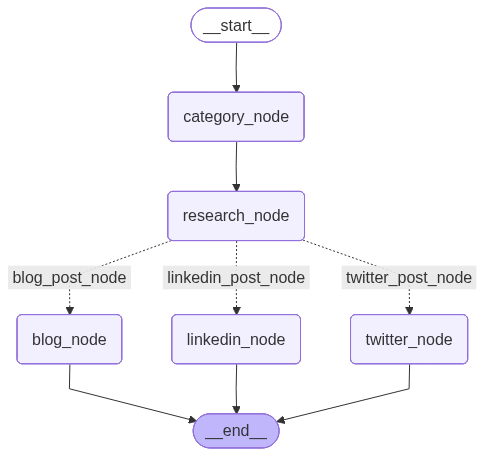

In [23]:
graph = StateGraph(AgentState)

graph.add_node("category_node", category_decider)

graph.add_node("twitter_node", twitter_post_node)
graph.add_node("linkedin_node", linkedin_post_node)
graph.add_node("blog_node", blog_post_node)
graph.add_node("research_node", research_node)


graph.add_edge(START, "category_node")

graph.add_edge("category_node", "research_node")

# router edges
graph.add_conditional_edges(
    "research_node",
    router_node,
    {
        "linkedin_post_node": "linkedin_node",
        "twitter_post_node": "twitter_node",
        "blog_post_node": "blog_node"
    }
)


app = graph.compile()
app

In [24]:
response = app.invoke({
    "user_input": "I want to generate a post about the latest trends in AI as per 2026 for linkedin",
    "topic": "",
    "category": "",
    "post": "",
    "research": ""
})

In [25]:
print(response["post"])

**🚀 AI 2026: What’s Shaping the Landscape Today?**  

The past year has turned the AI hype cycle into a **“Year of Truth.”** Organizations are moving from curiosity to measurable impact, and three forces are driving that shift:

| Trend | Why It Matters | Real‑World Example |
|-------|----------------|--------------------|
| **Open‑source & domain‑specific models are exploding** | Smaller, purpose‑built models now rival the size‑and‑scale of the old “big‑model” giants, delivering higher accuracy with lower compute cost. | IBM’s **Granite**, AI2’s **Olmo 3**, and **DeepSeek** models are already powering next‑gen R&D pipelines in biotech and materials science. |
| **AI as a discovery partner** | Beyond summarizing papers, AI is now co‑authoring experiments, suggesting hypotheses, and even designing molecules in chemistry or catalysts in physics. | Early pilots at leading research labs show AI‑driven hypothesis generation cutting experimental cycles by 30‑40 %. |
| **Enterprise‑wide trust

In [26]:
response

{'user_input': 'I want to generate a post about the latest trends in AI as per 2026 for linkedin',
 'topic': 'latest trends in AI 2026',
 'category': 'linkedin',
 'post': '**🚀 AI\u202f2026: What’s Shaping the Landscape Today?**  \n\nThe past year has turned the AI hype cycle into a **“Year of Truth.”** Organizations are moving from curiosity to measurable impact, and three forces are driving that shift:\n\n| Trend | Why It Matters | Real‑World Example |\n|-------|----------------|--------------------|\n| **Open‑source & domain‑specific models are exploding** | Smaller, purpose‑built models now rival the size‑and‑scale of the old “big‑model” giants, delivering higher accuracy with lower compute cost. | IBM’s **Granite**, AI2’s **Olmo\u202f3**, and **DeepSeek** models are already powering next‑gen R&D pipelines in biotech and materials science. |\n| **AI as a discovery partner** | Beyond summarizing papers, AI is now co‑authoring experiments, suggesting hypotheses, and even designing mol